# This script simulates a pendulum, adds noise, and fits it to demonstrate how we might arrive at a guess for natural angular frquency, and therefore L.

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use('dark_background')

In [73]:
# simulating a pendulum

# initial physical conditions
THETA_0 = np.pi/36 # 5 degrees
g = 9.80
L = 1.0 # meters
k = .5 # linear damping coef 
omega = np.sqrt(g/L)

def theta(t):
    # angle as function of time
    return THETA_0 * np.cos(omega * t)
def theta_dot(t):
    # angular velocity
    return -THETA_0 * omega * np.sin(omega*t)
def theta_double_dot(t):
    # angular acceleration
    return -THETA_0 * omega**2 * np.cos(omega*t) * np.exp(-k*t) # pretty sure this is how damping works...todo: check
def x_accel(t):
    # acceleration in the x-direction
    return g*np.cos(theta(t))

In [74]:
# simulate x-accleration and angular acceleration in the xy-plane for 5 seconds at .01sec resolution
time = np.arange(0,5, 0.01)
accel = []
rad_accel = []
for t in time:
    accel.append(x_accel(t))
    rad_accel.append(theta_double_dot(t))

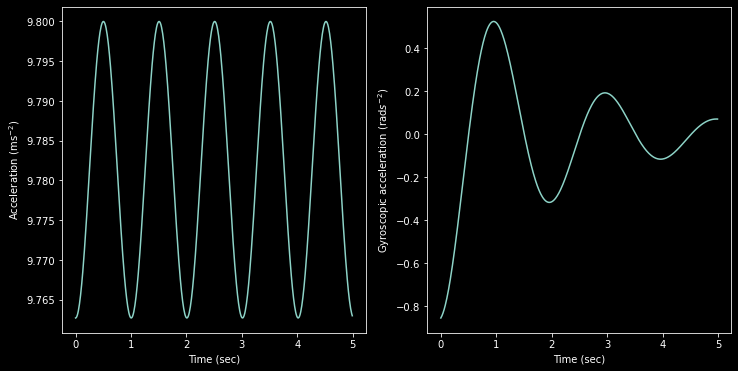

In [75]:
def show_plots():
    fig,ax = plt.subplots(1,2, figsize = (12, 6))
    ax[0].plot(time, accel)
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_ylabel('Acceleration (ms$^{-2}$)')
    ax[1].plot(time, rad_accel)
    ax[1].set_xlabel('Time (sec)')
    ax[1].set_ylabel('Gyroscopic acceleration (rad$s^{-2}$)')
show_plots()

In [76]:
# TODO: add damping term for x-acceleration

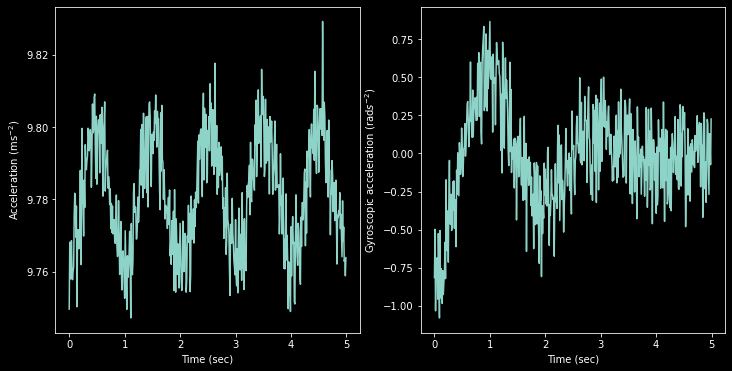

In [77]:
# add artificial noise
accel_noise = 0.008 * np.random.normal(size=len(accel))
rad_accel_noise = 0.2*np.random.normal(size=len(rad_accel))
accel+=accel_noise
rad_accel += rad_accel_noise

# show the plots again, now with noise
show_plots()

## The hardest part of the fitting is the guessing. You might have to run it many times, manually adjusting these parameters every time.

In [78]:
# parameter guesses
frequency = np.sqrt(9.8)
theta_initial = np.pi/36
k_guess = .5

In [79]:
# define functions designed for scipy's curve fit that can guess omega

def theta_accel(t, omega, k_factor):
    # this function is idential theta_double_dot above, 
    # but takes omega and THETA_0
    # I could have made them the same function but I didn't want to pass omega every time
    return -THETA_0 * omega**2 * np.cos(omega*t) * np.exp(-k_factor * t)

def x_accel_to_fit(x, frq, theta_init):
    # similar to above, it returns the same thing as x_accel but takes three variables instead of one
    # again, I'm making this specificially for the purposes of fitting frq an theta_init
    return g*np.cos(theta_init * np.cos(frq * x))

In [80]:
# this is where the actual fitting begins
parameters0 = [frequency, theta_initial]
parameters1 = [frequency, k_guess]

# popt is the list of optimal parameters, as determined by curve_fit
# pcov is the covariance matrix, whose diagonal entries are the variance of each parameter
popt0, pcov0 = curve_fit(x_accel_to_fit, time, accel, parameters0)
popt1, pcov1 = curve_fit(theta_accel, time, rad_accel, parameters1)

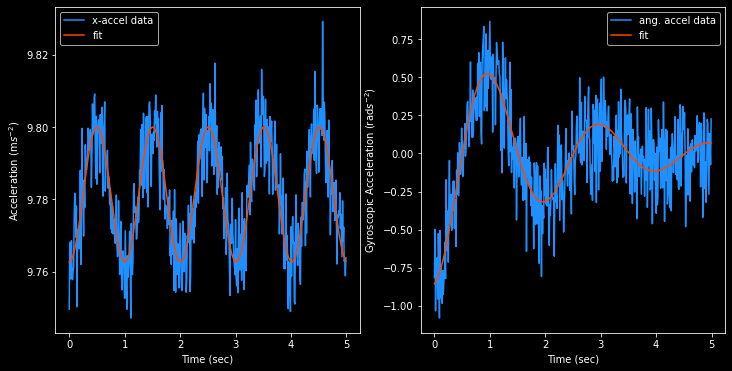

In [81]:
accel_fit = x_accel_to_fit(time, *parameters0)
rad_accel_fit = theta_accel(time, *parameters1)

fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].plot(time, accel, c = 'dodgerblue', label = 'x-accel data')
ax[0].plot(time, accel_fit, c= 'orangered', label = 'fit')
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('Acceleration (m$s^{-2}$)')
ax[0].legend()

ax[1].plot(time, rad_accel, c = 'dodgerblue', label = 'ang. accel data')
ax[1].plot(time, rad_accel_fit, c= 'orangered', label = 'fit')
ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('Gyroscopic Acceleration (rad$s^{-2}$)')
ax[1].legend()

## Success! Both curves look successfully fitted. <br>  Our ultimate goal is to find $\omega$, which we find like so: 

In [82]:
# omega found from fitting the x-acceleration, with its std dev as uncertainty:
print(popt0[0], '+/-', pcov0[0][0]**(1/2))

#omega found from fitting the angular acceleration, with its std dev as uncrtainty:
print(popt1[0], '+/-', pcov1[0][0]**(1/2))

3.126327291573601 +/- 0.0046095777964743866
3.1066570026850138 +/- 0.025239164890004138
